In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from celmech.nbody_simulation_utilities import set_time_step,align_simulation
from celmech.nbody_simulation_utilities import get_simarchive_integration_results
import rebound as rb
from os.path import isfile
from sympy import init_printing
init_printing()

In [2]:
from celmech.secular import LaplaceLagrangeSystem

In [3]:
try:
    sa = rb.SimulationArchive('sa_laplace_lagrange.bin')
except RuntimeError:
    mu1, mu2, mu3 = 1.5e-6, 1e-200, 1e-6
    P1, P2, P3 = 0.05*0.8, 0.05, 0.05*1.35
    ecc1, ecc2, ecc3 = 0.05,0.05,0.1
    pomega1, pomega2, pomega3 = 0,0,np.pi
    
    sim = rb.Simulation()
    sim.add(m=1.)
    sim.add(m=mu1, P=P1, e=ecc1, pomega=pomega1)
    sim.add(m=mu2, P=P2, e=ecc2, pomega=pomega2)
    sim.add(m=mu3, P=P3, e=ecc3, pomega=pomega3)
    ps = sim.particles
    ps[1].r = ps[1].a*(ps[1].m/3/ps[0].m)**(1/3)
    ps[2].r = ps[2].a*(ps[2].m/3/ps[0].m)**(1/3)

    sim.move_to_com()
    sim.integrator = "whfast"
    sim.dt = sim.particles[1].P/20
    sim.collision = "direct"
    align_simulation(sim)

    lsys = LaplaceLagrangeSystem.from_Simulation(sim)
    eigvals = lsys.eccentricity_eigenvalues()
    Tsec = np.max(np.abs(2 * np.pi / eigvals))
    sim.automateSimulationArchive('sa_laplace_lagrange.bin',interval=Tsec/2048,deletefile=True)
    sim.integrate(0.05*3e5)
    sa = rb.SimulationArchive('sa_laplace_lagrange.bin')

In [4]:
nb_results = get_simarchive_integration_results(sa)
sim = sa[0]
lsys = LaplaceLagrangeSystem.from_Simulation(sim)
sec_soln = lsys.secular_solution(nb_results['time'])

/mnt/ssd/miniconda3/envs/qiyang/lib/python3.10/site-packages/rebound/simulation.py:1982: FutureWarning: sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead
  warnings.warn( "sim.calculate_energy() is deprecated and will be removed in the future. Use sim.energy() instead", FutureWarning)


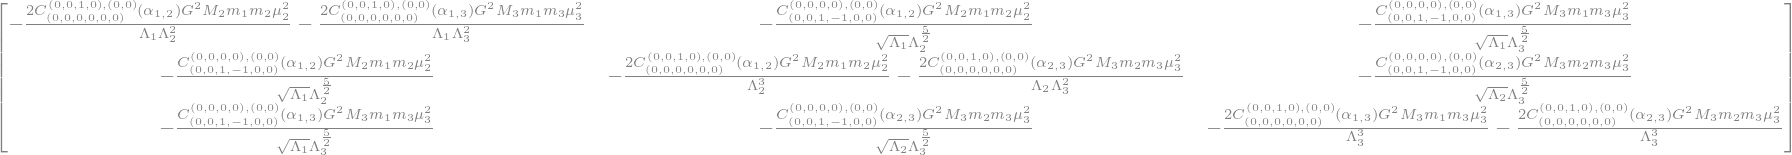

In [5]:
lsys.eccentricity_matrix

In [6]:
M = lsys.Neccentricity_matrix

In [7]:
m1, m2, m3 = 1.5e-6, 1e-200, 1e-6
m_tot = m1+m2+m3
R = np.array([[np.sqrt(m1/m_tot), np.sqrt(m2/m_tot), np.sqrt(m3/m_tot)],
             [-np.sqrt(m3/(m1+m3)), 0, np.sqrt(m1/(m1+m3))],
             [np.sqrt(m1*m2/(m1+m3)/m_tot), -np.sqrt((m1+m3)/m_tot), np.sqrt(m2*m3/(m1+m3)/m_tot)]])

In [8]:
np.matmul(np.matmul(R, M), np.transpose(R))

array([[-3.15706039e-05,  8.55497551e-06, -1.11521488e-10],
       [ 8.55497551e-06, -3.14279550e-04,  4.27302181e-11],
       [-1.11521488e-10,  4.27302181e-11, -1.85077661e-03]])